# Disaster Tweet Detection

In [9]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.10.0
KerasNLP version: 0.6.2


## Load dataset

In [11]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [12]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Explore the dataset

In [14]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


### Unique Tweet Locations

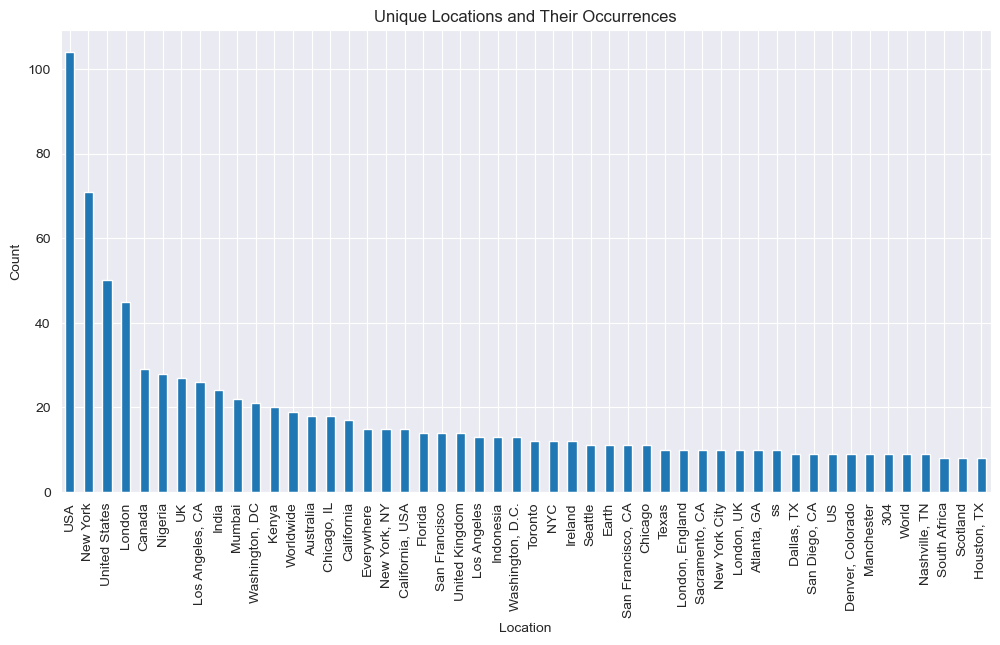

In [15]:
location_counts = df_train['location'].value_counts()
min_count = 8
filtered_location_counts = location_counts[location_counts >= min_count]
plt.figure(figsize=(12, 6))
filtered_location_counts.plot(kind='bar')
plt.title('Unique Locations and Their Occurrences')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

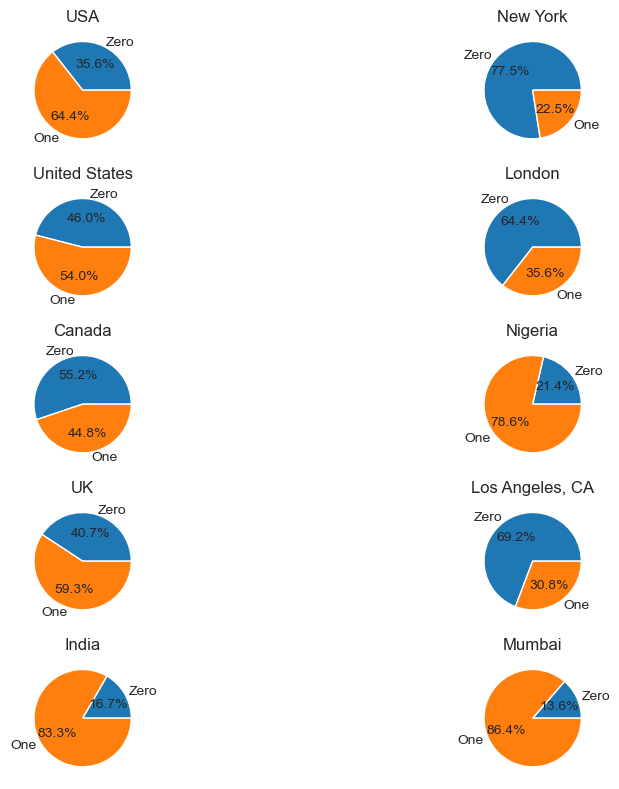

In [16]:
location_counts = df_train.groupby("location")["target"].value_counts().unstack().fillna(0)

# Get the top ten locations by the total count (sum of ones and zeros)
top_ten_locations = location_counts.sum(axis=1).nlargest(10).index

# Filter the location_counts DataFrame for the top ten locations
location_counts = location_counts.loc[top_ten_locations]

# Create a figure with a grid of pie charts for the top ten locations
num_locations = len(top_ten_locations)
num_columns = 2  # Number of columns in the grid (you can adjust this)
num_rows = (num_locations + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    if i < num_locations:
        location_data = location_counts.loc[top_ten_locations[i]]
        ax.pie(location_data, labels=["Zero", "One"], autopct="%1.1f%%")
        ax.set_title(top_ten_locations[i])
    else:
        # Hide empty subplots
        ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()